In [26]:
# Ιωάννης Χουλιάρας --- AM: 2631
# Παρουσίαση δεύτερου ερωτήματος της τελικής εργασίας στο μάθημα επιλογής Υπολογιστική Όραση.

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # removes annoying warning.
import sys
import tarfile
import tempfile
import cv2
import tensorflow as tf
import numpy as np
from six.moves import urllib
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [3]:
#Η έκδοση του tensorflow && της python:
print('tensorflow: ' + tf.__version__)
print('Python: ' + sys.version)

tensorflow: 1.8.0
Python: 3.6.10 |Anaconda, Inc.| (default, May  7 2020, 23:06:31) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]


In [28]:
class DeepLabModel(object):
    '''
    Here is the class of the model. I changes the OUTPUT_TENSOR_NAME to
    'concat_projection/Relu:0'
    Returns the resized image and seg_map.
    seg_map now is a tensor (_,_,256) where we will perform PCA
    '''
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'concat_projection/Relu:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    def __init__(self, tarball_path):
        """Creates and loads pretrained deeplab model."""
        self.graph = tf.Graph()

        graph_def = None
        # Extract frozen graph from tar archive.
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.GraphDef.FromString(file_handle.read())
                break

        tar_file.close()

        if graph_def is None:
            raise RuntimeError('Cannot find inference graph in tar archive.')

        with self.graph.as_default():
            tf.import_graph_def(graph_def, name='')

        self.sess = tf.Session(graph=self.graph)

    def run(self, image):
        width, height = image.size
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = image.convert('RGB').resize(
            target_size, Image.ANTIALIAS)
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [np.asarray(resized_image)]})
        seg_map = batch_seg_map[0]
        return resized_image, seg_map  # seg_map is the tensor, use that later for PCA

In [29]:
def get_model():
    '''
    With this function we download the pretrained model:
    'deeplabv3_xception_ade20k_train_2018_05_29'
    When we download it succesfully we return it to a variable
    for future use from main. We don't need to include the other URL's
    '''
    MODEL_NAME = 'deeplabv3_xception_ade20k_train_2018_05_29'  # using ade20k model
    # _MODEL_URL = 'deeplabv3_xception_ade20k_train_2018_05_29.tar.gz'  # tar file
    # delete this.
    _MODEL_URL = 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz'
    _DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'
    _TARBALL_NAME = 'deeplab_model.tar.gz'
    model_dir = tempfile.mkdtemp()
    tf.gfile.MakeDirs(model_dir)
    download_path = os.path.join(model_dir, _TARBALL_NAME)
    print('downloading model, this might take a while...')
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + _MODEL_URL,
                               download_path)
    print('download completed! loading DeepLab model...')
    model = DeepLabModel(download_path)
    print('model loaded successfully!')
    return model

In [30]:
def get_deep_feature(image, MODEL):
    ''' 
    In this function we will run the visualization. (MODEL.run)
    We will get the tensor with shape (_,_,256) where we can perform
    the PCA to drop the dimension to d = 3
    '''
    try:
        original_image = Image.open(image)
    except IOError:
        print('Cannot retrieve image. Please check the name')
        return
    print('running deeplab on image %s...' % image)
    return MODEL.run(original_image)  # returns reshaped_image, seg_map

In [31]:
def perform_pca(deepfeats):
    '''
    In this function, we perform PCA to drop the dimension of the tensor to d = 3
    Code was given from the professor on github [https://github.com/dip-course/pca_on_deepfeatures]
    A tensor with H x W x C, we reshape it to an array of HW x C (pixels x dimension of data)
    '''
    N = deepfeats.shape[0]*deepfeats.shape[1]
    C = deepfeats.shape[-1]
    X = np.reshape(deepfeats, [N, C])
    print('Τα αρχικά δεδομένα μου έχουν μέγεθος: {}'.format(X.shape))
    Xreduced = PCA(n_components=3).fit_transform(X)
    print('Μετά το PCA έχουμε μέγεθος: {}'.format(Xreduced.shape))
    return Xreduced

In [58]:
def visualization(after_pca, deepfeats, name, image):
    img = cv2.imread(image)
    deepfeats_reduced = np.reshape(
        after_pca, [deepfeats.shape[0], deepfeats.shape[1], 3])
    print(deepfeats_reduced.shape)
    fig = plt.figure(figsize=(20,20))
    plt.subplot(1,2,1)
    plt.imshow(deepfeats_reduced)
    plt.subplot(1,2,2)
    plt.imshow(img)
    plt.show()

In [34]:
MODEL = get_model()

downloading model, this might take a while...
download completed! loading DeepLab model...
model loaded successfully!


running deeplab on image dining.jpg...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Τα αρχικά δεδομένα μου έχουν μέγεθος: (4225, 256)
Μετά το PCA έχουμε μέγεθος: (4225, 3)
(65, 65, 3)


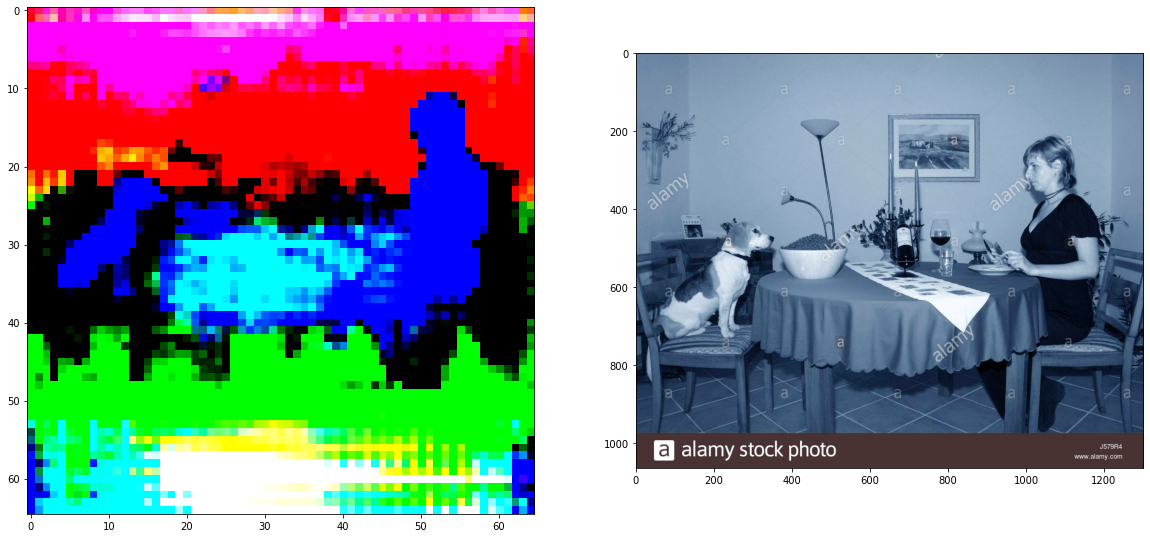

In [59]:
'''
Here we will see some examples
'''

image1 = 'dining.jpg'
output = 'none.jpg'

_, deep_feature = get_deep_feature(image1, MODEL)
after_pca = perform_pca(deep_feature)
visualization(after_pca, deep_feature, output, image1)

running deeplab on image office.jpg...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Τα αρχικά δεδομένα μου έχουν μέγεθος: (4225, 256)
Μετά το PCA έχουμε μέγεθος: (4225, 3)
(65, 65, 3)


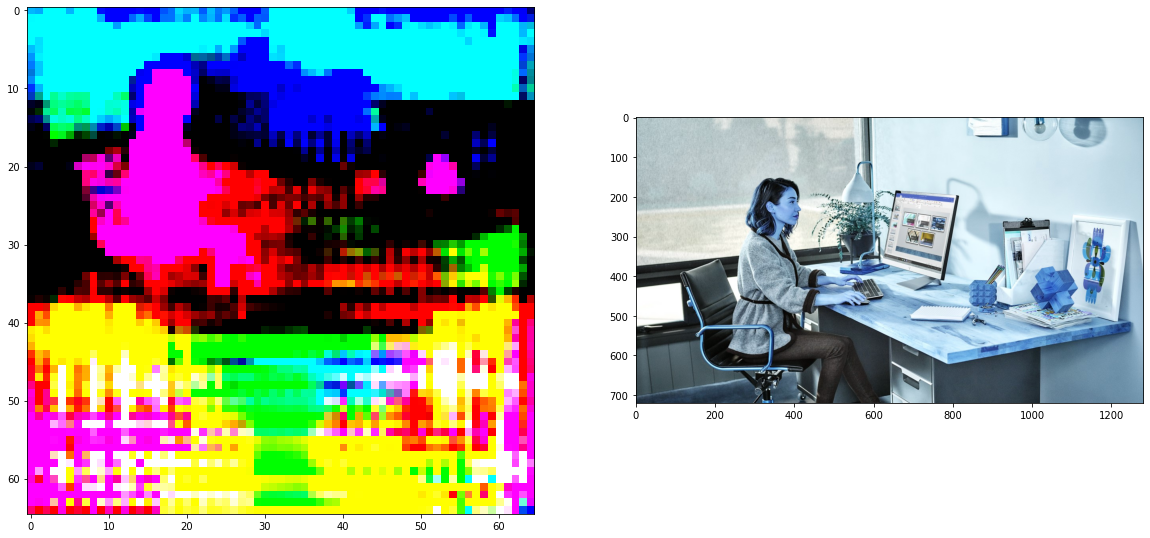

In [60]:
image2 = 'office.jpg'
output = 'none.jpg'

_, deep_feature = get_deep_feature(image2, MODEL)
after_pca = perform_pca(deep_feature)
visualization(after_pca, deep_feature, output, image2)

running deeplab on image city.jpg...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Τα αρχικά δεδομένα μου έχουν μέγεθος: (4225, 256)
Μετά το PCA έχουμε μέγεθος: (4225, 3)
(65, 65, 3)


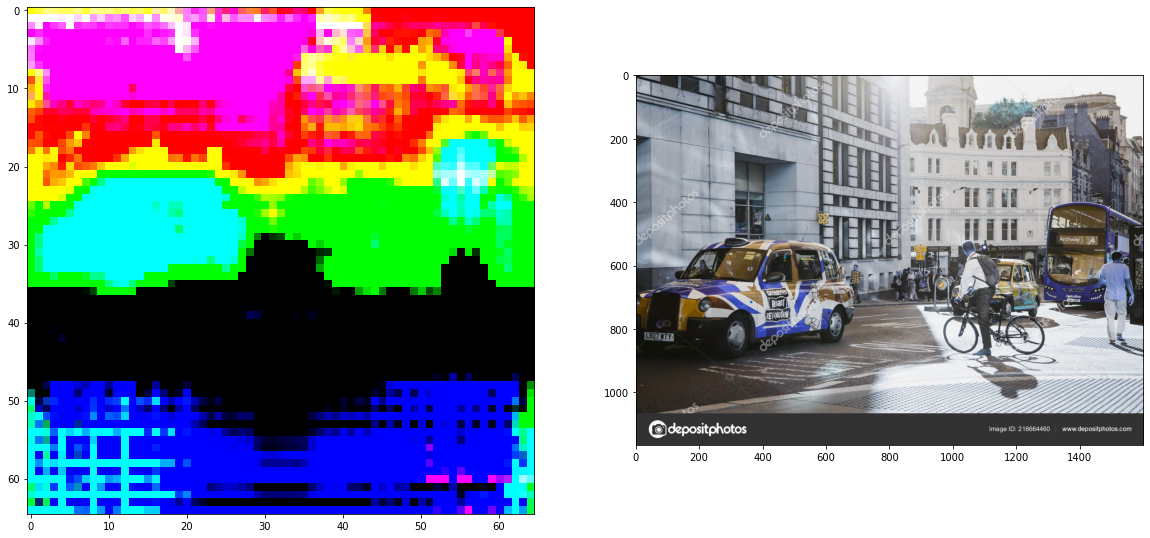

In [61]:
image3 = 'city.jpg'
output = 'none.jpg'

_, deep_feature = get_deep_feature(image3, MODEL)
after_pca = perform_pca(deep_feature)
visualization(after_pca, deep_feature, output, image3)

running deeplab on image horse_man.jpg...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Τα αρχικά δεδομένα μου έχουν μέγεθος: (4225, 256)
Μετά το PCA έχουμε μέγεθος: (4225, 3)
(65, 65, 3)


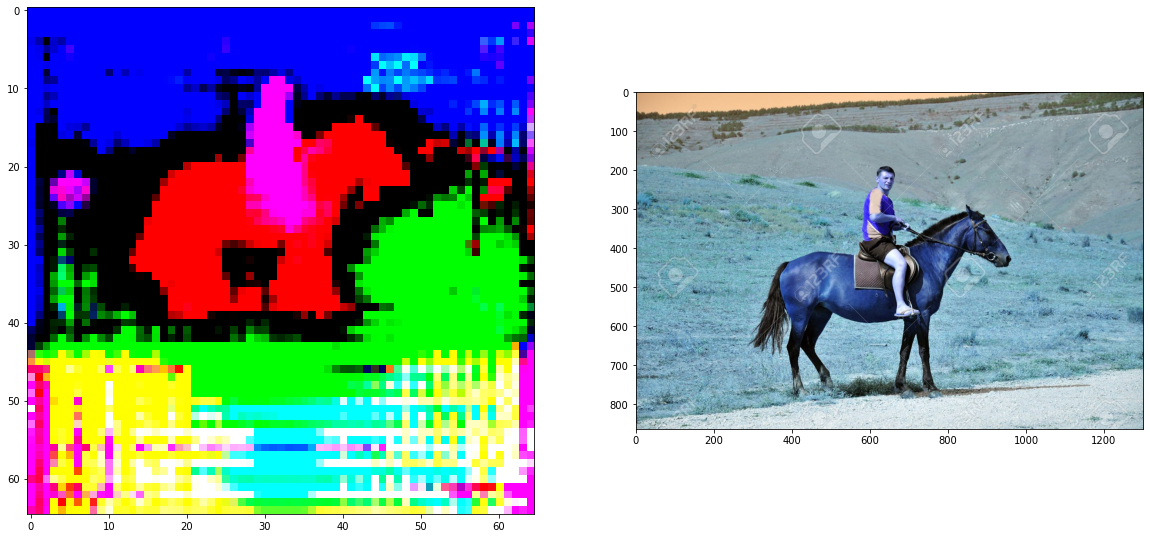

In [62]:
image4 = 'horse_man.jpg'
output = 'none.jpg'

_, deep_feature = get_deep_feature(image4, MODEL)
after_pca = perform_pca(deep_feature)
visualization(after_pca, deep_feature, output, image4)

running deeplab on image plane_train.jpg...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Τα αρχικά δεδομένα μου έχουν μέγεθος: (4225, 256)
Μετά το PCA έχουμε μέγεθος: (4225, 3)
(65, 65, 3)


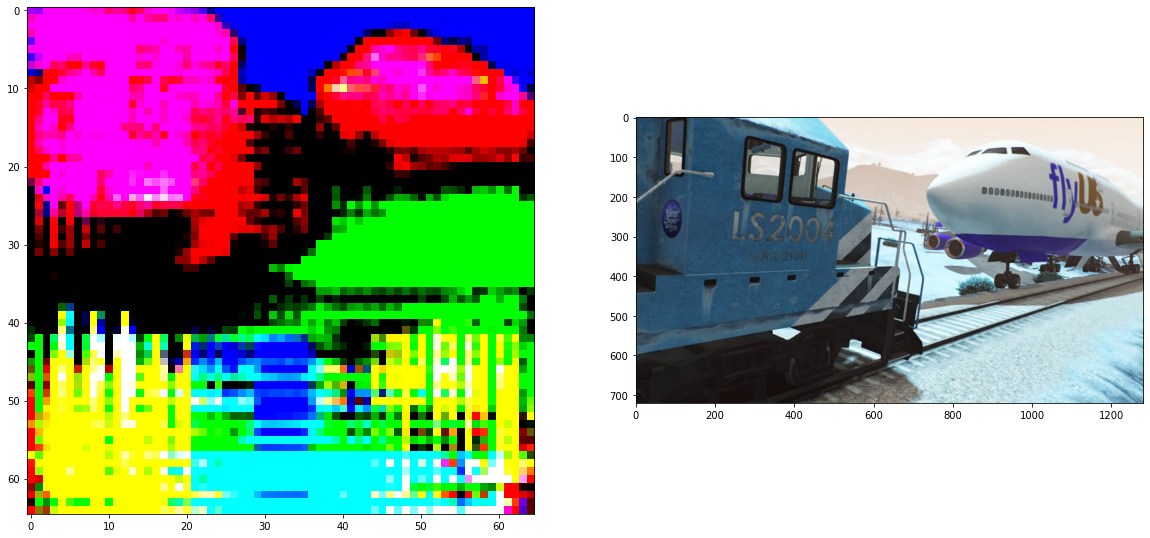

In [63]:
image5 = 'plane_train.jpg'
output = 'none.jpg'

_, deep_feature = get_deep_feature(image5, MODEL)
after_pca = perform_pca(deep_feature)
visualization(after_pca, deep_feature, output, image5)